In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
# Import and read credit card fraud train file for preprocessing and analysis
ccf_df = pd.read_csv("dataset/fraudTrain.csv",parse_dates=['trans_date_trans_time',])

ccf_df['trans_hour'] = ccf_df.trans_date_trans_time.dt.hour

ccf_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0


In [4]:
ccf_df['trans_hourEnc'] = 0
ccf_df.loc[ccf_df.trans_hour < 5,'trans_hourEnc'] = 1
ccf_df.loc[ccf_df.trans_hour > 21,'trans_hourEnc'] = 1

In [5]:
# verify column names and data types: 23 columns and 129,675 rows before pre-processing
ccf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   category               1296675 non-null  object        
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   gender                 1296675 non-null  object        
 9   street                 1296675 non-null  object        
 10  city                   1296675 non-null  object        
 11  state                  1296675 non-null  object        
 12  zip                    12966

In [6]:
# confirm number of fraudulant transactions:
fraud = len(ccf_df[ccf_df.is_fraud == 1])
nonfraud = len(ccf_df[ccf_df.is_fraud == 0])
print("Fraud:", fraud); print("Non-fraud", nonfraud)


Fraud: 7506
Non-fraud 1289169


In [7]:
# print percentage distibution of fraudulant transactions in dataset
percent_fraud = (fraud / (fraud + nonfraud))*100
percent_nonfraud = (nonfraud / (fraud + nonfraud))*100

print("Fraudulant:", round(percent_fraud,2),"% of total transactions")
print("NonFraudulant:", round(percent_nonfraud,2),"% of total transactions")


Fraudulant: 0.58 % of total transactions
NonFraudulant: 99.42 % of total transactions


In [8]:
# Drop columns not needed for analysis: Unnamed column from dataset
ccf_df = ccf_df.drop(columns=['Unnamed: 0'])
ccf_df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_hourEnc
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


In [9]:
# Extract frequencies of transactions in last 1/7/30 days
def last1DayTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_1_day').sort_index()
    count_1_day = temp.rolling('1d').count() - 1
    count_1_day.index = temp.values
    x['count_1_day'] = count_1_day.reindex(x.index)
    return x
def last7DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_7_days').sort_index()
    count_7_days = temp.rolling('7d').count() - 1
    count_7_days.index = temp.values
    x['count_7_days'] = count_7_days.reindex(x.index)
    return x
def last30DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_30_days').sort_index()
    count_30_days = temp.rolling('30d').count() - 1
    count_30_days.index = temp.values
    x['count_30_days'] = count_30_days.reindex(x.index)
    return x

In [10]:
transCount_df = ccf_df.groupby('cc_num').apply(last1DayTransactionCount)


In [11]:
transCount_df = transCount_df.groupby('cc_num').apply(last7DaysTransactionCount)


In [12]:
transCount_df = transCount_df.groupby('cc_num').apply(last30DaysTransactionCount)
transCount_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_hourEnc,count_1_day,count_7_days,count_30_days
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,0.0,0.0,0.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,0.0,0.0,0.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,0.0,0.0,0.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,0.0,0.0,0.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,12,0,3.0,21.0,86.0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,12,0,1.0,6.0,30.0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,12,0,3.0,36.0,139.0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,12,0,0.0,24.0,133.0


In [13]:
def timeDifference(x):
    x['time_diff'] = x.trans_date_trans_time - x.trans_date_trans_time.shift()
    return x

In [15]:
transCount_df = transCount_df.groupby('cc_num').apply(timeDifference)

In [16]:
transCount_df['time_diff'] = transCount_df['time_diff'].dt.seconds

In [17]:
transCount_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_hourEnc,count_1_day,count_7_days,count_30_days,time_diff
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1325376018,36.011293,-82.048315,0,0,1,0.0,0.0,0.0,NaN
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1325376044,49.159047,-118.186462,0,0,1,0.0,0.0,0.0,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,1325376051,43.150704,-112.154481,0,0,1,0.0,0.0,0.0,NaN
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1325376076,47.034331,-112.561071,0,0,1,0.0,0.0,0.0,NaN
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,1325376186,38.674999,-78.632459,0,0,1,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,1371816728,36.841266,-111.690765,0,12,0,3.0,21.0,86.0,16781.0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,1371816739,38.906881,-78.246528,0,12,0,1.0,6.0,30.0,7962.0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,1371816752,33.619513,-105.130529,0,12,0,3.0,36.0,139.0,29074.0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,1371816816,42.788940,-103.241160,0,12,0,0.0,24.0,133.0,4618.0


Text(0.5, 1.0, 'Correlation heatmap without generated features')

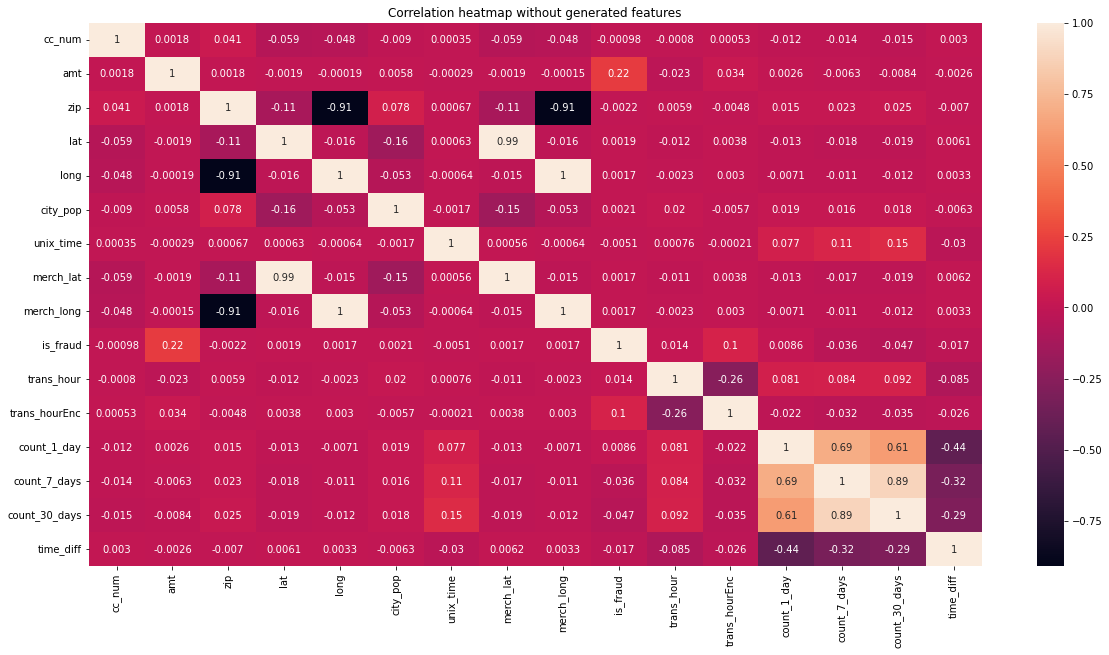

In [20]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(transCount_df.corr(),annot=True).set_title('Correlation heatmap without generated features')

In [21]:
transCount_df.corr()['is_fraud'].abs().sort_values(ascending=False)

is_fraud         1.000000
amt              0.219404
trans_hourEnc    0.101077
count_30_days    0.046523
count_7_days     0.036301
time_diff        0.016876
trans_hour       0.013799
count_1_day      0.008638
unix_time        0.005078
zip              0.002162
city_pop         0.002136
lat              0.001894
merch_lat        0.001741
merch_long       0.001721
long             0.001721
cc_num           0.000981
Name: is_fraud, dtype: float64